## 作業
在鐵達尼資料集中，
透過進階補值方法 KNN，將鐵達尼號中的 Titanic_train
.csv 中的 age 的遺失值進行補值。    
* step1: 觀察 Age 和 Pclass 與 Sex 是否有關連性?
* step2: 如果有關連性，運用 KNN ，取出 Age 、 Pclass、 Sex的資料，以 Sex 與 Pclass 補 Age 遺失值。 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import math
from scipy import stats
import seaborn as sns
from IPython.display import display
import sklearn
from sklearn import preprocessing
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn.impute import KNNImputer

%matplotlib inline

## 讀入資料

## 觀察 Age

In [2]:
df_train = pd.read_csv("Titanic_train.csv")

In [3]:
# 觀察各變數是否有遺失值，並計算遺失率
missing_rates = df_train.isnull().sum() / len(df_train)
missing_rates.sort_values(ascending=False)
missing_rates = pd.DataFrame(missing_rates, columns=["missing_rates"])
print(missing_rates)

             missing_rates
PassengerId       0.000000
Survived          0.000000
Pclass            0.000000
Name              0.000000
Sex               0.000000
Age               0.198653
SibSp             0.000000
Parch             0.000000
Ticket            0.000000
Fare              0.000000
Cabin             0.771044
Embarked          0.002245


C:\Users\benao\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


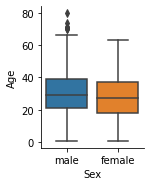

In [4]:
# 觀察 Age 和 Pclass 與 Sex 是否有關連性?
#觀察性別和年齡分布
g = sns.catplot("Sex", "Age", data=df_train, kind="box", height=2.5, aspect=0.8)
# 男女年齡分布大致相同，約在20~40歲之間，女姓年齡略低於男姓

C:\Users\benao\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


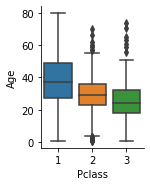

In [5]:
# 觀察年齡和艙房等級的關聯
g = sns.catplot("Pclass", "Age", data=df_train, kind="box", height=2.5, aspect=0.8)
# 大多數25~50歲住第一級房，住第二級房者有年輕人、小孩、長者，可能是家庭房，第三級房客主要是20~30歲年輕人，及長者

In [6]:
# 如果有關連性，運用 KNN ，取出 Age 、 Pclass、 Sex的資料，以 Sex 與 Pclass 補 Age 遺失值。
# 離散轉連續資料
le = preprocessing.LabelEncoder()
df_train["Sex"] = le.fit_transform(df_train["Sex"])
display(df_train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,C


In [7]:
# 計算資料點的兩兩距離
# 先截取需要用到的數值資料
df_train_c = df_train.filter(["Sex", "Age", "Pclass"], axis=1)
df_train_cnum = pd.DataFrame(nan_euclidean_distances(df_train_c))
np.where((df_train_cnum > 0) & (df_train_cnum < 0.05))       

(array([ 17,  17,  78,  78,  78,  78,  78,  78,  78,  78,  78, 181, 181,
        277, 277, 413, 413, 466, 466, 481, 481, 547, 547, 674, 674, 732,
        732, 831, 831, 831, 831, 831, 831, 831, 831, 831], dtype=int64),
 array([ 78, 831,  17, 181, 277, 413, 466, 481, 547, 674, 732,  78, 831,
         78, 831,  78, 831,  78, 831,  78, 831,  78, 831,  78, 831,  78,
        831,  17, 181, 277, 413, 466, 481, 547, 674, 732], dtype=int64))

In [12]:
# 透過 KNN 進行補值
# k=1, weights=uniform
df_train_c1u = df_train_c.copy()
num_neighbors = 1
imputer = KNNImputer(n_neighbors=num_neighbors, add_indicator=True)
df_filled = pd.DataFrame(imputer.fit_transform(df_train_c1u))
display(df_filled)

,0,1,2,3
0,1.0,22.0,3.0,0.0
1,0.0,38.0,1.0,0.0
2,0.0,26.0,3.0,0.0
3,0.0,35.0,1.0,0.0
4,1.0,35.0,3.0,0.0
...,...,...,...,...
886,1.0,27.0,2.0,0.0
887,0.0,19.0,1.0,0.0
888,0.0,26.0,3.0,1.0
889,1.0,26.0,1.0,0.0


In [13]:
# k=3, weights=uniform
df_train_c3u = df_train_c.copy()
num_neighbors = 3
imputer = KNNImputer(n_neighbors=num_neighbors, add_indicator=True)
df_filled = pd.DataFrame(imputer.fit_transform(df_train_c3u))
display(df_filled)

,0,1,2,3
0,1.0,22.0,3.0,0.0
1,0.0,38.0,1.0,0.0
2,0.0,26.0,3.0,0.0
3,0.0,35.0,1.0,0.0
4,1.0,35.0,3.0,0.0
...,...,...,...,...
886,1.0,27.0,2.0,0.0
887,0.0,19.0,1.0,0.0
888,0.0,19.0,3.0,1.0
889,1.0,26.0,1.0,0.0


In [14]:
# k=1, weights=distance
df_train_c1d = df_train_c.copy()
num_neighbors = 1
imputer = KNNImputer(n_neighbors=num_neighbors, weights="distance", add_indicator=True)
df_filled = pd.DataFrame(imputer.fit_transform(df_train_c1d))
display(df_filled)

,0,1,2,3
0,1.0,22.0,3.0,0.0
1,0.0,38.0,1.0,0.0
2,0.0,26.0,3.0,0.0
3,0.0,35.0,1.0,0.0
4,1.0,35.0,3.0,0.0
...,...,...,...,...
886,1.0,27.0,2.0,0.0
887,0.0,19.0,1.0,0.0
888,0.0,26.0,3.0,1.0
889,1.0,26.0,1.0,0.0


In [15]:
# k=3, weights=distance
df_train_c3d = df_train_c.copy()
num_neighbors = 3
imputer = KNNImputer(n_neighbors=num_neighbors, weights="distance", add_indicator=True)
df_filled = pd.DataFrame(imputer.fit_transform(df_train_c3d))
display(df_filled)

,0,1,2,3
0,1.0,22.0,3.0,0.0
1,0.0,38.0,1.0,0.0
2,0.0,26.0,3.0,0.0
3,0.0,35.0,1.0,0.0
4,1.0,35.0,3.0,0.0
...,...,...,...,...
886,1.0,27.0,2.0,0.0
887,0.0,19.0,1.0,0.0
888,0.0,19.0,3.0,1.0
889,1.0,26.0,1.0,0.0
